# EXERCICE 7 : REGRESSION LINEAIRE MULTIPLE AVEC REGULARISATION + VALIDATION CROISEE


Inspire de http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_and_elasticnet.html


In [1]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error


#### Génération de donnée synthétiques...

In [2]:

np.random.seed(31)

#... definition de n et p
n = 75
p =  200   #remarque : n<200 => necessite de selectionner des variables

#... simulation de X
X = np.random.randn(n, p) #remarque : on ne tient pas en compte les $beta_0$

#... generation du vecteur beta dans lequel seules 10 valeurs sont non-nulles
beta = 3 * np.random.randn(p)
inds = np.arange(p)
np.random.shuffle(inds)
beta[inds[10:]] = 0 

#... simulation de y 
y = np.dot(X, beta) + (2.0 * np.random.normal(size=n))


# REMARQUE IMPORTANTE : y ne dépend que des variables i pour lesquelles beta[i] est non-nul


# ... coupe en deux les donnees en donnees d'apprentissage et donnes test
thresh=n // 2
X_train = X[thresh:]
y_train = y[thresh:]
X_test = X[:thresh]
y_test = y[:thresh]


#### Régression linéaire avec régularisation Lasso ...


In [3]:

from sklearn.linear_model import Lasso

alpha = 0.5
lasso_regressor = Lasso(alpha=alpha)
lasso_regressor.fit(X_train, y_train)

y_pred_lasso = lasso_regressor.predict(X_test)
mse_score_lasso = mean_squared_error(y_test, y_pred_lasso)


####  Représentation du résultat


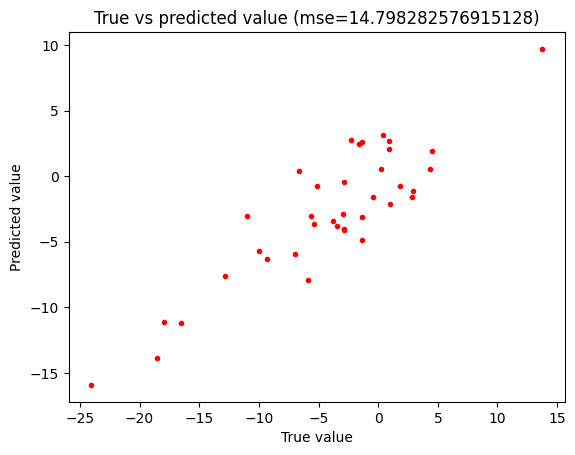

In [4]:
fig = plt.figure()
plt.plot(y_test, y_pred_lasso, 'r.')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title('True vs predicted value (mse='+str(mse_score_lasso)+')')
plt.show()



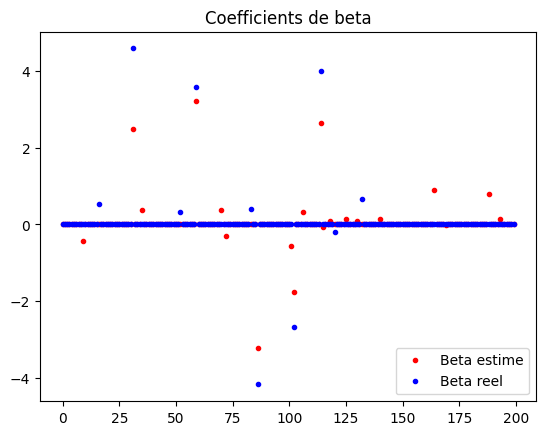

In [5]:

fig = plt.figure()
plt.plot(lasso_regressor.coef_, 'r.')
plt.plot(beta, 'b.')
plt.legend(('Beta estime', 'Beta reel'), loc='lower right')
plt.title('Coefficients de beta')
plt.show()



### <span style="color:blue">QUESTION 1</span> :

Jouez l'exemple avec  n=1000, n=100, n=75, n=50, n=25. Qu'en deduisez vous sur l'impact du nombre d'observations

### <span style="color:blue">REPONSE 1</span> :

Le nombre d'observations permet d'obtenir une régression plus juste qui permet de meilleures prédictions, et une moindre dispertion des estimations de beta permettant d'obtenir une droite, mais augmente le risque de surapprentissage, et donc risque de nuire à la qualité des prédictions. 



### <span style="color:blue">QUESTION 2</span> :

On garde n=75. Utilisez la validation croisee de type K-folds (typiquement 8-Folds) pour trouver le meilleur coefficient *alpha* au sens de la MSE. Pour chaque *alpha* testé, on gardera comme score la MSE moyenne obtenue sur tous les *folds*.

Remarque : la recherche d'un bon coefficient *alpha* pourra d'abord se faire sur une échelle exponentielle assez large (ex: 0.001, 0.01, 0.1, ...) puis être raffinée sur une échelle plus fine.  

### <span style="color:blue">REPONSE 2</span> :

In [27]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
import numpy as np

# Définir la liste des alphas à tester
alphas_coarse = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
alphas_fine = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

# Données d'apprentissage (X_train, y_train)

# Nombre de folds pour la validation croisée
n_folds = 8
kf = KFold(n_splits=n_folds)

best_alpha = None
best_mse = float('inf')

for alpha_coarse in alphas_coarse:
    for alpha_fine in alphas_fine:
        alpha = alpha_coarse * alpha_fine
        mse_sum = 0.0
        for train_idx, val_idx in kf.split(X_train):
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

            # Créez et ajustez un modèle Ridge avec l'alpha actuel
            ridge = Ridge(alpha=alpha)
            ridge.fit(X_train_fold, y_train_fold)

            # Prédisez sur les données de validation et calculez la MSE
            y_val_pred = ridge.predict(X_val_fold)
            mse_fold = mean_squared_error(y_val_fold, y_val_pred)
            mse_sum += mse_fold

        # Calculez la MSE moyenne pour cet alpha
        mse_avg = mse_sum / n_folds

        # Mettez à jour le meilleur alpha si nécessaire
        if mse_avg < best_mse:
            best_mse = mse_avg
            best_alpha = alpha

print("Meilleur alpha trouvé :", best_alpha)
print("MSE moyenne correspondante :", best_mse)


Meilleur alpha trouvé : 100
MSE moyenne correspondante : 63.4711404931306


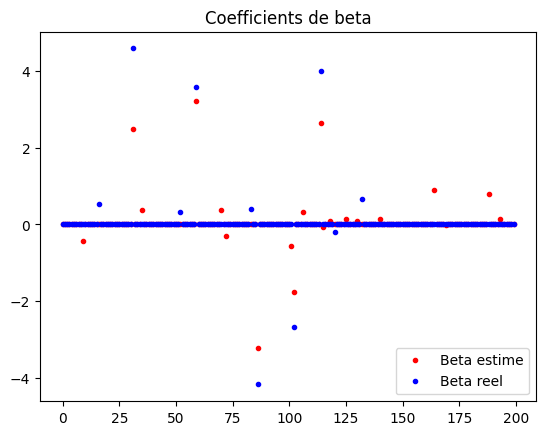

In [6]:
#représentation des coefficients estimés (lasso_regressor.coef_) et de ceux
#avec lesquels les données ont été simulées (beta)

fig = plt.figure()
plt.plot(lasso_regressor.coef_, 'r.')
plt.plot(beta, 'b.')
plt.legend(('Beta estime', 'Beta reel'), loc='lower right')
plt.title('Coefficients de beta')
plt.show()


### <span style="color:blue">QUESTION 3</span> :

De manère alternative, codez et testez maintenant une sélection de type *forward* avec un critère de sélection *BIC*.

Comparez les résultats avec ceux obtenus à l'aide de la pénalisation LASSO.

### <span style="color:blue">REPONSE 3</span> :


In [29]:
from sklearn.linear_model import LinearRegression
import numpy as np


# Créez une fonction pour ajuster un modèle et calculer le BIC
def fit_and_bic(X, y, selected_features):
    lr = LinearRegression()
    lr.fit(X[:, selected_features], y)
    y_pred = lr.predict(X[:, selected_features])
    n = len(y)
    mse = np.mean((y - y_pred) ** 2)
    num_features = len(selected_features)
    bic = n * np.log(mse) + num_features * np.log(n)
    return mse, bic

# Initialisation des variables
n_features = X_train.shape[1]
selected_features = []
best_bic = float('inf')

# Boucle pour sélectionner les caractéristiques
while True:
    best_mse = float('inf')
    best_feature = None

    # Essayez d'ajouter chaque caractéristique non sélectionnée
    for feature in range(n_features):
        if feature not in selected_features:
            mse, bic = fit_and_bic(X_train, y_train, selected_features + [feature])
            if bic < best_bic:
                best_bic = bic
                best_mse = mse
                best_feature = feature

    # Si l'ajout d'une caractéristique ne diminue pas le BIC, arrêtez la boucle
    if best_feature is None:
        break

    # Ajoutez la meilleure caractéristique à la sélection
    selected_features.append(best_feature)
    print("Caractéristique ajoutée :", best_feature)
    print("MSE correspondante :", best_mse)
    print("BIC correspondant :", best_bic)

# Utilisez le modèle final pour effectuer des prédictions
lr_final = LinearRegression()
lr_final.fit(X_train[:, selected_features], y_train)
y_pred = lr_final.predict(X_test[:, selected_features])

# Évaluez la performance avec la MSE
mse_final = np.mean((y_test - y_pred) ** 2)
print("MSE finale :", mse_final)


Caractéristique ajoutée : 86
MSE correspondante : 51.10644166600974
BIC correspondant : 153.1261870317947
Caractéristique ajoutée : 59
MSE correspondante : 30.067723751457482
BIC correspondant : 136.60635956035344
Caractéristique ajoutée : 31
MSE correspondante : 15.055716061051836
BIC correspondant : 113.95955198389764
Caractéristique ajoutée : 114
MSE correspondante : 8.80756414118968
BIC correspondant : 97.22355936222486
Caractéristique ajoutée : 102
MSE correspondante : 4.422183390902736
BIC correspondant : 74.68000584926307
Caractéristique ajoutée : 32
MSE correspondante : 3.4930012077691215
BIC correspondant : 69.35444679889474
Caractéristique ajoutée : 18
MSE correspondante : 2.6334353129163994
BIC correspondant : 62.258092584285436
Caractéristique ajoutée : 137
MSE correspondante : 2.080254045054557
BIC correspondant : 56.93531016323256
Caractéristique ajoutée : 163
MSE correspondante : 1.683099568151305
BIC correspondant : 52.52248427122049
Caractéristique ajoutée : 70
MSE cor